# Quantum Simulation

This project is meant to show how a quantum simulation could be performed using quantum computing. In practice, many of the functions used here cannot be used on real quantum computers (like using the `statevectors`). Nonetheless, with a stable enough source of qubits, all of these steps could be implemented using clever methods (like measuring the phases in the bloch sphere in each iteration to calculate the actual state instead of just the probability amplitude). 

Nonetheless, this project is meant to provide pragmatic methods that can usually be implemented when working with simulation-backends.

## From $\ket{0}$ 's and $\ket{1}$ 's to $\psi(x)$:

We discretize our spatial dimension using each different state as a point in space (with the coefficient being the value of the wavefunction at this point.)

In [85]:
import os
import numpy as np
import matplotlib.pyplot as plt

import qiskit as q
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT, DiagonalGate, PauliEvolutionGate
from qiskit.synthesis.evolution import LieTrotter

## Setup initial parameters

We want to discretize our 'grid' for the wavefunction. If we have $k$ quibts, our grid will be able to have $2^k$ points (corresponding to each possible basis state)

In [94]:
# --- Parameters ---
n = 7                 # number of qubits -> 2**n grid points
N = 2 ** n            # number of grid points (= number of total basis states)
k0 = .5             # initial momentum parameter
m = 1              # mass
hbar = 1.0           # reduced Planck's constant
dt = 1e-2             # time step
t_tot = 1.0          # total time
L = 4.0            # domain is [0, xlim]
frames_dir = "frames"

os.makedirs(frames_dir, exist_ok=True)

# spatial grid
x = np.linspace(0, L, N, endpoint=False)  # choose endpoint
                                             # =False to align sampling
dx = L / N

## Define the gates we will use
For a time independent Hamiltonian $\hat{H}$, without much rigour we can see that 
$$
    \ket{\psi(t)} = e^{-i\hat{H}t} \ket{\psi_0}
$$
satisfies the Schrödinger equation

And so we discretize!

To do this, notice that we will have to find a diagonal operator which satisfy $\hat D\ket{m} = m\ket{m}$, where $m$ inside the ket should be thought of as written in a binary basis: $$m = m_0 2^0 + m_1 2^1 + \ldots m_{n-1} 2^{n-1} \qquad m_i \in \{0, 1\} $$

Notice that, if we consider the thid Pauli matrix $Z \equiv \sigma_z = \begin{pmatrix} 1 &0 \\0 & -1\end{pmatrix}$ acting on the $j$-th qubit (call it $Z_j$), then $Z_j \ket{m_j} = (1 - 2m_j)\ket{m_j}$ (i.e. $Z\ket{0} = \ket{0}, \; Z\ket{1} = -\ket{1}$). Thus, $$\hat D_j \ket{m_j} \equiv 2^j \frac{\mathbb{1}_j - Z_j}{2}\ket{m_j} = 2^j m_j \ket{m_j}$$ will get us the desired operator $D$ if we consider $\hat D =  \hat D_0 + \hat D_1 +\ldots+ \hat D_{n-1}$.

Note that, being more precise, we should really be tensoring times the identity over all other qubits in each term, but we will ignore that to mantain a clean notation.

After creating that operator, we can define (in a free theory, for example) a kinetic operator via $e^{i \hat H \Delta t} = e^{i \frac{\hat{D}^2}{2m} \Delta t}$ in the momentum eigenbasis.

The implementation is slightly different that expected as Qiskit works with reverse order, but the idea is the same

In [87]:
def Dhat(n: int) -> SparsePauliOp:
    """
    Build K-hat using left-to-right strings like: I...I Z I...I (qubit 0 on the left),
    then convert to Qiskit's Pauli-string convention internally.

    """
    paulis = []
    coeffs = []

    # Identity coefficient: sum_j 2^j / 2 = (2^n - 1)/2
    paulis.append("I" * n)
    coeffs.append((2**n - 1) / 2)

    for j in range(n):
        weight = 2**j

        # Your left-to-right string: j I's, then Z, then n-j-1 I's
        s_left = ("I" * j) + "Z" + ("I" * (n - j - 1))

        # Convert to Qiskit convention (rightmost char = qubit 0)
        s_qiskit = s_left[::-1]

        paulis.append(s_qiskit)
        coeffs.append(-weight / 2)

    return SparsePauliOp(paulis, coeffs)

Dhat(3).to_matrix()

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 2.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 3.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 4.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 5.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 6.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 7.+0.j]])

One can check that this exactly reproduces the expected results (as $\ket{000} = \begin{pmatrix}1\\0\\ \vdots\\0\end{pmatrix}$, $\ket{100} = \begin{pmatrix}0\\1\\ 0 \\\vdots\end{pmatrix}$ and so on). 

In fact, this is indicative that we can simply treat this as a multiplication by a diagonal matrix in momentum space when working with the kinetic term. We will work with this approach in what follows, as it is more straightforward to do a momentum shift in Fourier space in this case.

We will now procede to define the state $\ket{\Psi}$ in our basis.

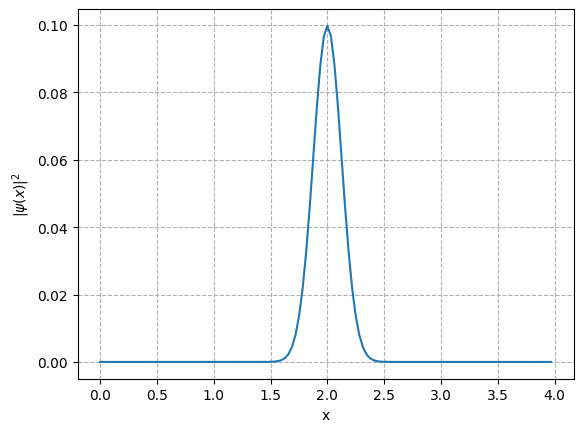

In [95]:
# initial wavefunction in position space (complex)
psi = np.exp(-(4 * (x-L/2))**2) * np.exp(1j * k0 * x)
psi = psi.astype(complex)
psi /= np.linalg.norm(psi)
plt.plot(x, np.abs(psi)**2)
plt.xlabel("x")
plt.grid(ls="--")
plt.ylabel(r"$|\psi(x)|^2$");

And then the circuit that we will use to act.

In [88]:
def time_evolution_circuit(n: int, dt: float, m: float, L: float, hbar: float=1.0) -> QuantumCircuit:
    N = 2**n
    k = np.arange(N, dtype=int)
    k_signed = np.where(k < N//2, k, k - N)  # 0..N/2-1, -N/2..-1
    p = (2 * np.pi * hbar / L) * k_signed    # momentum values consistent with FFT sampling
    phases = np.exp(-1j * (p**2) * dt / (2*m)) # kinetic evolution phases to make a diagonal matrix in Fourier space

    qc = QuantumCircuit(n)
    qft = QFT(n, do_swaps=True)          # <-- key change
    qc.append(qft, range(n))
    qc.append(DiagonalGate(phases.tolist()), range(n))
    qc.append(qft.inverse(), range(n))
    return qc

qc = time_evolution_circuit(n=3, dt=0.1, m=1.0, L=L)
print(qc.decompose().draw())   # one level

global phase: 5.6047
     ┌──────┐┌──────────────────────────────────────────┐»
q_0: ┤0     ├┤0                                         ├»
     │      ││                                          │»
q_1: ┤1 QFT ├┤1 Ucrz(-0.12337,-0.61685,0.86359,0.37011) ├»
     │      ││                                          │»
q_2: ┤2     ├┤2                                         ├»
     └──────┘└──────────────────────────────────────────┘»
«                                                 ┌───────┐
«q_0: ────────────────────────────────────────────┤0      ├
«     ┌────────────────────────┐                  │       │
«q_1: ┤0                       ├──────────────────┤1 IQFT ├
«     │  Ucrz(-0.74022,1.2337) │┌────────────────┐│       │
«q_2: ┤1                       ├┤ Ucrz(-0.49348) ├┤2      ├
«     └────────────────────────┘└────────────────┘└───────┘


/var/folders/f1/7ltqqtrs0bd73b4q_hz5s1x80000gn/T/ipykernel_28029/2697502701.py:9: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(n, do_swaps=True)          # <-- key change


/var/folders/f1/7ltqqtrs0bd73b4q_hz5s1x80000gn/T/ipykernel_28029/2697502701.py:9: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(n, do_swaps=True)          # <-- key change


Simulation complete.


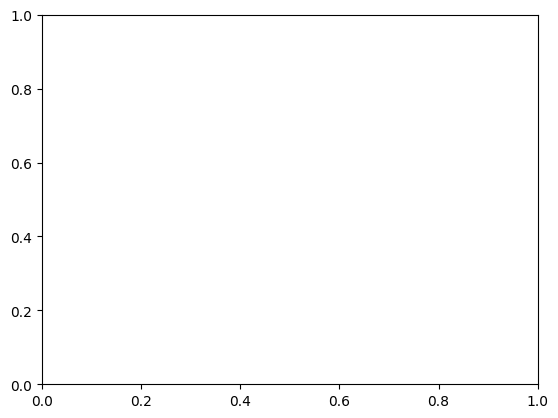

In [96]:
# Time loop
ts = np.arange(0.0, t_tot, dt)
# psi = psi0_x.copy()

for i, t in enumerate(ts):

    # Plot probability density
    plt.plot(x, np.abs(psi)**2);
    plt.xlabel("x")
    plt.ylabel(r"$|\psi(x)|^2$")
    plt.grid(ls=':')
    plt.title(f"t = {t:.2f} with momentum kick $k_0=${k0}")
    plt.grid(ls="--")
    plt.axis([0, L, 0, 1.2 * np.max(np.abs(psi)**2)])
    plt.savefig(f"frames/frame_{i:04d}.png")
    plt.cla();

    # Evolve statevector directly (NO backend)
    sv = Statevector(psi)
    sv = sv.evolve(time_evolution_circuit(n, dt, m, L))

    psi = np.asarray(sv.data)

print("Simulation complete.");

_Note:_ An easy generalization for a hamiltonian with potential naturally arises from this method, with the exponential-of-potential term to be implemented outside of the Fourier Space. Its implementation is left as an exercise. 

And then we can proceed to animate with our favorite `animate` function (all images of the states are already saved in a folder __frames__)